Sample Transactions:
   TransactionAmount  TransactionTime  CustomerAge  Fraud
0          66.902867               20           41      0
1          83.683794               19           32      0
2          89.722662               18           50      0
3          90.812782                7           53      0
4         104.220349               13           25      0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       950
           1       0.96      0.96      0.96        50

    accuracy                           1.00      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       1.00      1.00      1.00      1000



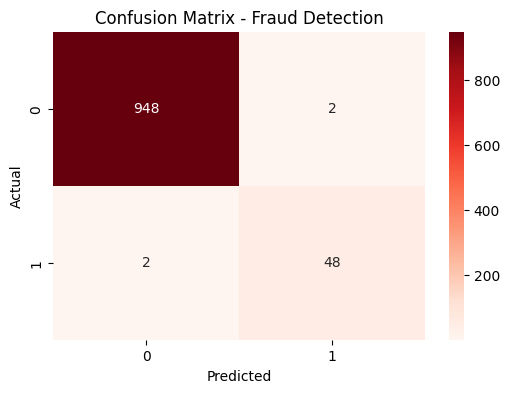

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Autoencoder Fraud Detection Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       950
           1       0.30      0.30      0.30        50

    accuracy                           0.93      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.93      0.93      0.93      1000


✅ Dataset with predictions saved as 'fraud_detection_results.csv'


In [1]:
# ===============================
# Financial Fraud Detection & Risk Analytics (Ready-to-Run)
# Author: Amrutha Varshini Billu
# ===============================

# Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn tensorflow

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 2: Create Synthetic Financial Transactions Dataset
np.random.seed(42)
n_transactions = 1000

# Generate normal transactions
normal = pd.DataFrame({
    'TransactionAmount': np.random.normal(100, 20, int(n_transactions*0.95)),
    'TransactionTime': np.random.randint(0, 24, int(n_transactions*0.95)),
    'CustomerAge': np.random.randint(18, 70, int(n_transactions*0.95)),
    'Fraud': 0
})

# Generate fraudulent transactions
fraud = pd.DataFrame({
    'TransactionAmount': np.random.normal(500, 50, int(n_transactions*0.05)),
    'TransactionTime': np.random.randint(0, 24, int(n_transactions*0.05)),
    'CustomerAge': np.random.randint(18, 70, int(n_transactions*0.05)),
    'Fraud': 1
})

data = pd.concat([normal, fraud]).reset_index(drop=True)
data = data.sample(frac=1).reset_index(drop=True)  # Shuffle

print("Sample Transactions:")
print(data.head())

# Step 3: Preprocessing
features = ['TransactionAmount', 'TransactionTime', 'CustomerAge']
X = data[features]
y = data['Fraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)
preds = iso_forest.predict(X_scaled)
# Convert predictions: -1 = anomaly (fraud), 1 = normal
preds = np.where(preds == -1, 1, 0)  # 1 = Fraud, 0 = Normal

# Step 5: Evaluation
print("\nClassification Report:")
print(classification_report(y, preds))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y, preds), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Fraud Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 6: Optional: Simple Autoencoder for Fraud Detection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build autoencoder
autoencoder = Sequential([
    Dense(8, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(X_scaled.shape[1], activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
y_pred_ae = (mse > threshold).astype(int)

print("\nAutoencoder Fraud Detection Classification Report:")
print(classification_report(y, y_pred_ae))

# Step 7: Save dataset and predictions
data['Predicted_Fraud_IF'] = preds
data['Predicted_Fraud_AE'] = y_pred_ae
data.to_csv("fraud_detection_results.csv", index=False)
print("\n✅ Dataset with predictions saved as 'fraud_detection_results.csv'")
